In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.rolling import RollingWLS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from pmdarima.model_selection import RollingForecastCV
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import itertools
import optuna

C:\Users\ADMIN\miniconda3\envs\Datascience\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Business Understanding

Q: Can you predict the future stock price for the investment?
A: Predicting the price for a perticular date using predictive modeling can determine the date is good for investment or not.

# Analytical Approach

Here we are using the predictive model approach. Machine learning model can be Auto Regressive models

# Data Requirement

We predicting future stcok value for NVDIA India stock. Best source to collect data is yfinance api.

# Data Collection

In [3]:
nvidia_instance = yf.Ticker('NVDA')
stock_info =nvidia_instance.info
print(f"Country of stock :{stock_info["country"]}\n\n",f"Business Summary :{stock_info["longBusinessSummary"]}")

Country of stock :United States

 Business Summary :NVIDIA Corporation, a computing infrastructure company, provides graphics and compute and networking solutions in the United States, Singapore, Taiwan, China, Hong Kong, and internationally. The Compute & Networking segment includes its Data Centre accelerated computing platforms and artificial intelligence solutions and software; networking; automotive platforms and autonomous and electric vehicle solutions; Jetson for robotics and other embedded platforms; and DGX Cloud computing services. The Graphics segment offers GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure, and solutions for gaming platforms; Quadro/NVIDIA RTX GPUs for enterprise workstation graphics; virtual GPU or vGPU software for cloud-based visual and virtual computing; automotive platforms for infotainment systems; and Omniverse software for building and operating industrial AI and digital twin applications. It also cu

# Data Understanding

In [4]:
stock_data = nvidia_instance.history(period='2y')

In [5]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-08 00:00:00-05:00,49.484436,52.245898,49.451454,52.223907,642510000,0.0,0.0
2024-01-09 00:00:00-05:00,52.371829,54.294758,51.661223,53.110416,773100000,0.0,0.0
2024-01-10 00:00:00-05:00,53.586152,54.569601,53.459220,54.319740,533796000,0.0,0.0
2024-01-11 00:00:00-05:00,54.968373,55.315180,53.530175,54.791470,596759000,0.0,0.0
2024-01-12 00:00:00-05:00,54.589585,54.939392,54.299749,54.679535,352994000,0.0,0.0


In [6]:
stock_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-12-29 00:00:00-05:00,187.710007,188.759995,185.910004,188.220001,120006100,0.0,0.0
2025-12-30 00:00:00-05:00,188.240005,188.990005,186.929993,187.539993,97687300,0.0,0.0
2025-12-31 00:00:00-05:00,189.570007,190.559998,186.490005,186.500000,120100500,0.0,0.0
2026-01-02 00:00:00-05:00,189.839996,192.929993,188.259995,188.850006,148240500,0.0,0.0
2026-01-05 00:00:00-05:00,191.759995,193.630005,186.149994,188.119995,182659400,0.0,0.0


In [7]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2024-01-08 00:00:00-05:00 to 2026-01-05 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          500 non-null    float64
 1   High          500 non-null    float64
 2   Low           500 non-null    float64
 3   Close         500 non-null    float64
 4   Volume        500 non-null    int64  
 5   Dividends     500 non-null    float64
 6   Stock Splits  500 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.2 KB


In [86]:
stock_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,501.000000,501.000000,501.000000,501.000000,5.010000e+02,501.000000,501.000000
mean,130.669365,132.800919,128.203903,130.628510,2.996387e+08,0.000148,0.019960
std,36.664583,36.795673,36.290978,36.515370,1.537065e+08,0.001187,0.446767
min,47.458558,48.157166,47.293649,47.542511,6.552850e+07,0.000000,0.000000
25%,107.270527,110.839880,104.715182,108.053741,1.849052e+08,0.000000,0.000000
50%,129.954469,132.203847,127.125562,129.906418,2.510647e+08,0.000000,0.000000
75%,158.182271,158.692214,155.942534,157.972305,3.780130e+08,0.000000,0.000000
max,208.068415,212.178195,205.548551,207.028473,1.142269e+09,0.010000,10.000000


#### Visualise the data

In [8]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

[]

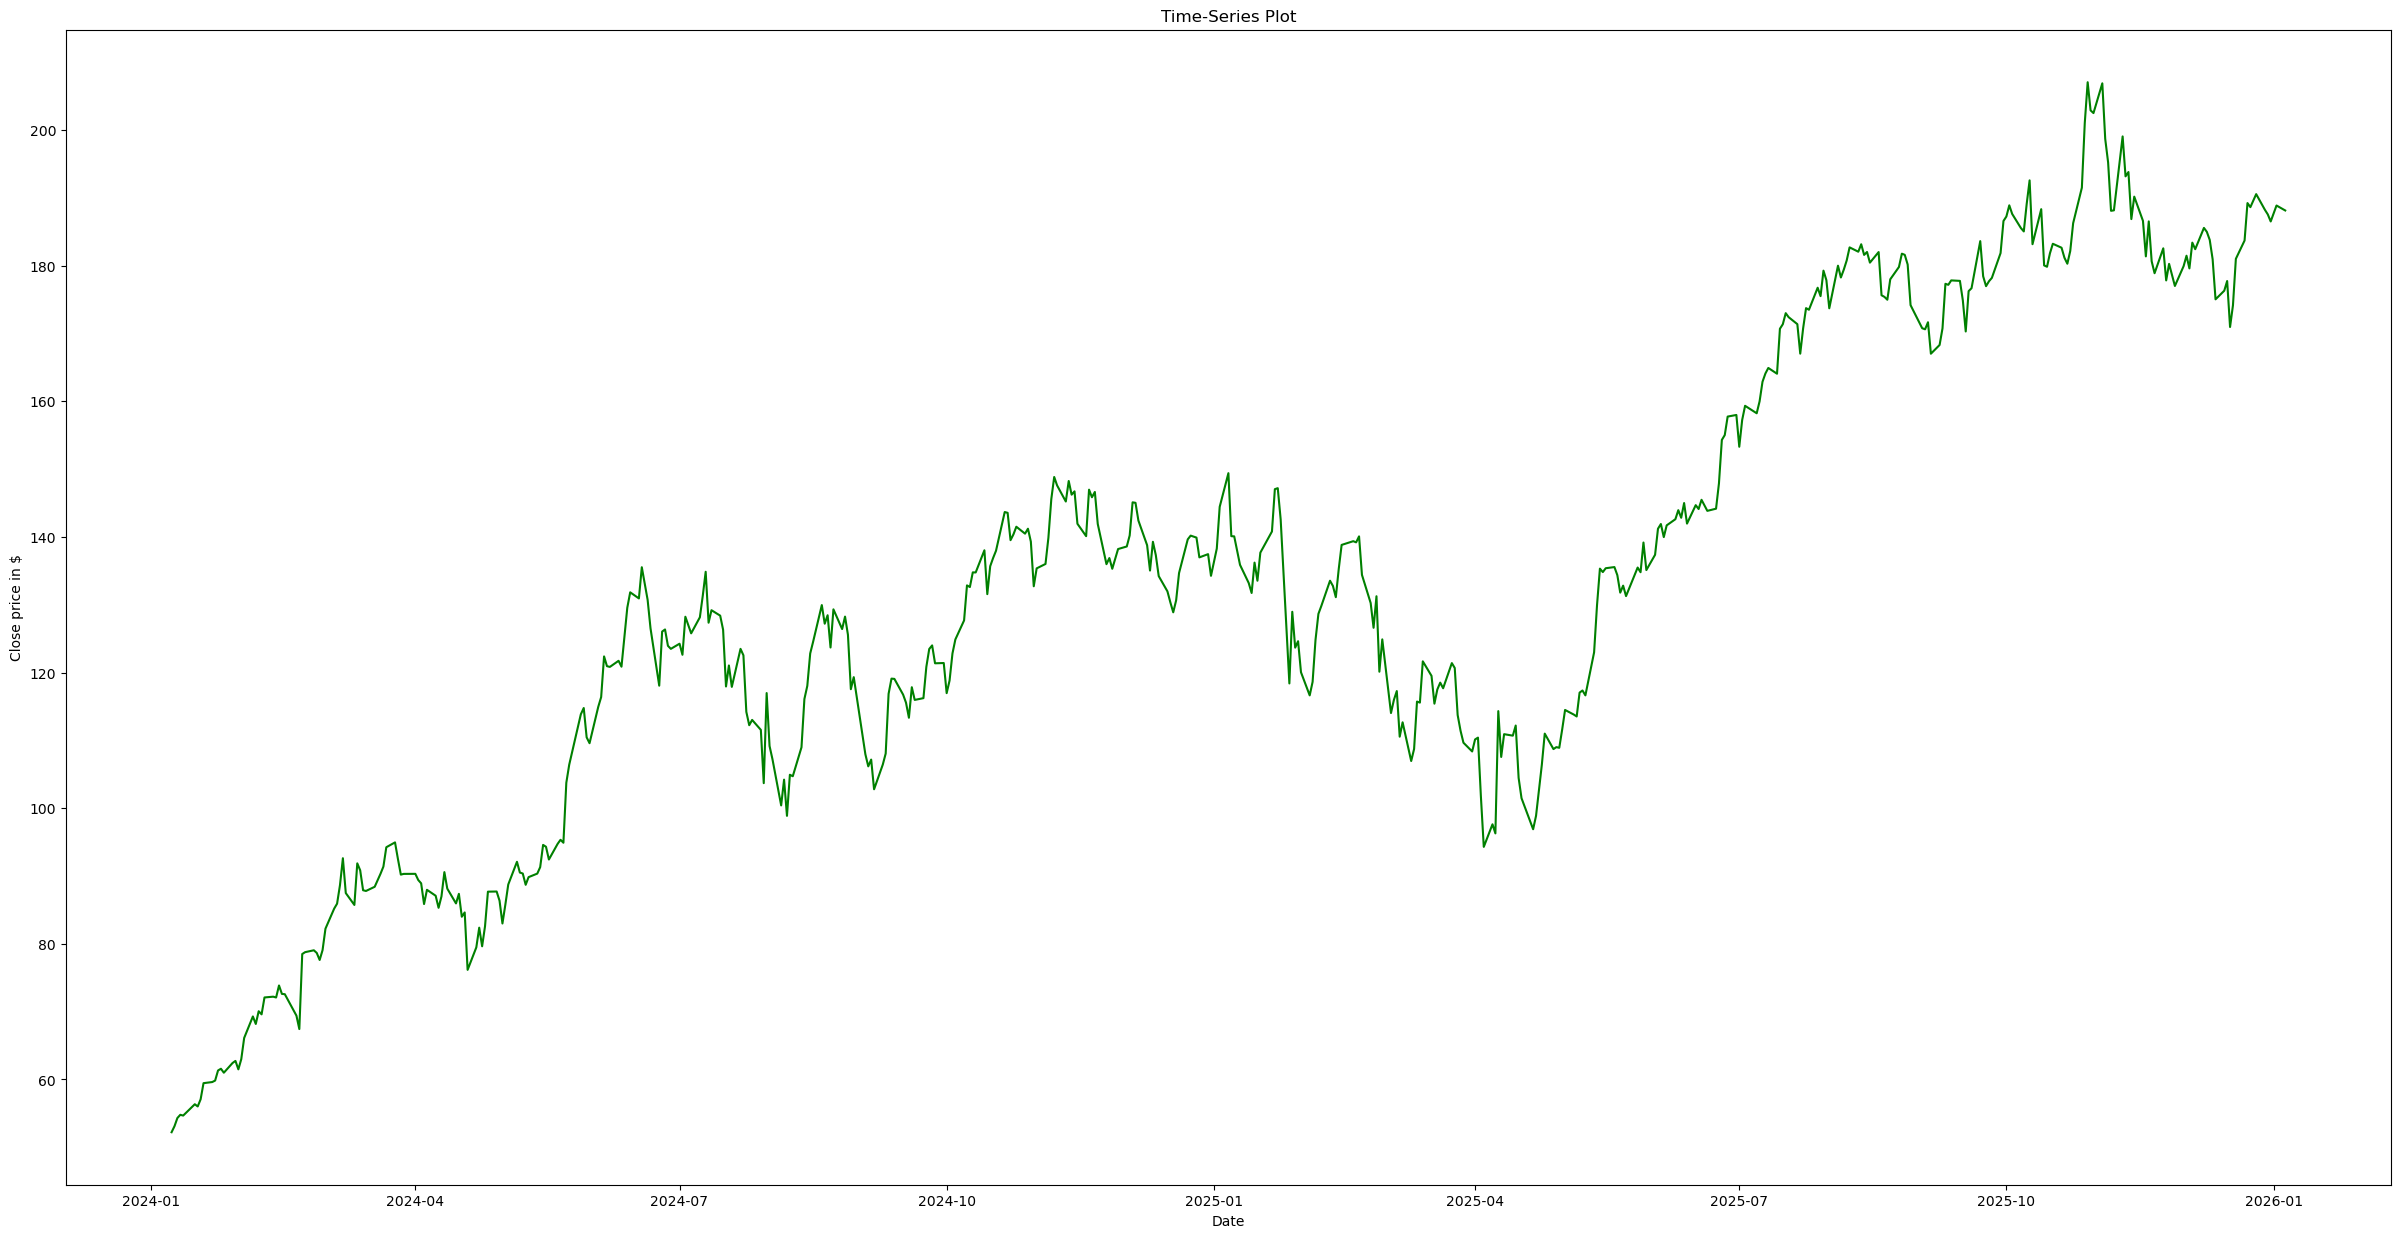

In [9]:
fig,ax = plt.subplots(figsize=(30, 15))
x = pd.to_datetime(stock_data.index)
y = stock_data["Close"]
ax.plot(x,y,color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Close price in $')
ax.set_title("Time-Series Plot")
ax.plot()

# Data Preparation

In [10]:
df = pd.DataFrame(stock_data["Close"])

In [11]:
df.index = pd.to_datetime(df.index)

#### Seasonal decomposition

In [12]:
stl = STL(df, period=12)
result = stl.fit()

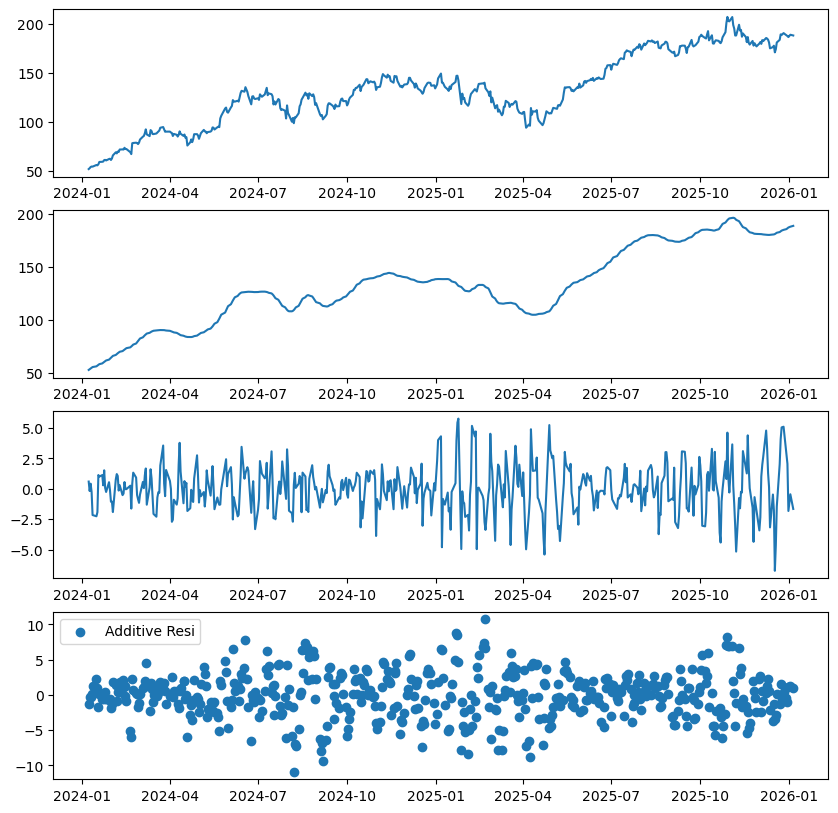

In [13]:
fig,ax = plt.subplots(4,1,figsize=(10,10))

ax[0].plot(result.observed, label='Observed')
plt.legend()
ax[1].plot(result.trend, label='Additive Trend')
plt.legend()
ax[2].plot(result.seasonal, label='Additive Seasonal')
plt.legend()
ax[3].scatter(result.resid.index,result.resid.values ,label='Additive Resi')
plt.legend()


#### Auto-correlation with lag values

In [14]:
auto_corr = acf(df,nlags=10)

In [15]:
auto_corr

array([1.        , 0.98675158, 0.97474112, 0.96174832, 0.94974683,
       0.93815821, 0.9270453 , 0.91586467, 0.90516849, 0.89477355,
       0.88480432])

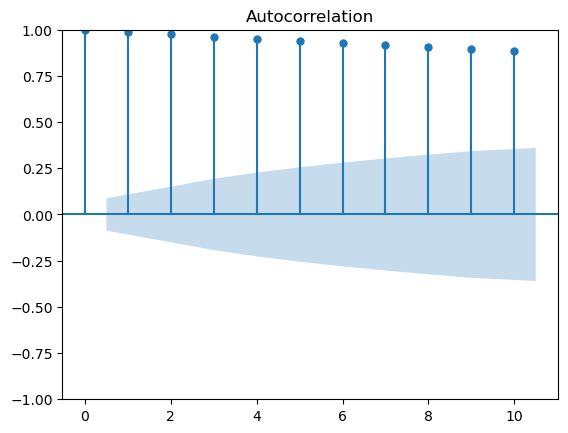

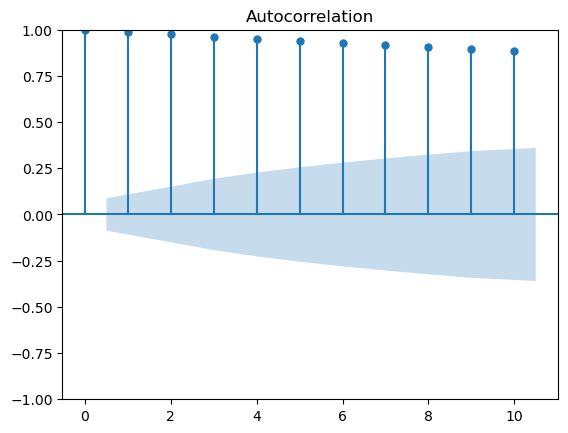

In [16]:
plot_acf(df, lags=10)

###  Rolling Correlation

In [20]:
# Simple Moving Average correlation for two months
df_rolling=df.copy()

df_rolling["roll_1"]=df.rolling(window=3).mean()
df_rolling["roll_2"]=df.rolling(window=6).mean()
df_rolling["roll_3"]=df.rolling(window=9).mean()
df_rolling["roll_4"]=df.rolling(window=12).mean()

df_rolling.loc['2025-11-01':'2026-01-05',:].corr()

,Close,roll_1,roll_2,roll_3,roll_4
Close,1.000000,0.917973,0.805619,0.682716,0.584612
roll_1,0.917973,1.000000,0.935926,0.815145,0.704342
roll_2,0.805619,0.935926,1.000000,0.942372,0.832645
roll_3,0.682716,0.815145,0.942372,1.000000,0.953002
roll_4,0.584612,0.704342,0.832645,0.953002,1.000000


#### Plotting Simple moving average and Exponential Moving Average

In [21]:
df_5month = df.loc['2025-11-01':'2026-01-05',:]

sma_window = 3  # 7-day moving average
sma = df_5month.rolling(window=sma_window).mean()
ema_window = 30  # 30-day moving average
ema = df_5month.ewm(span=ema_window, adjust=False).mean()

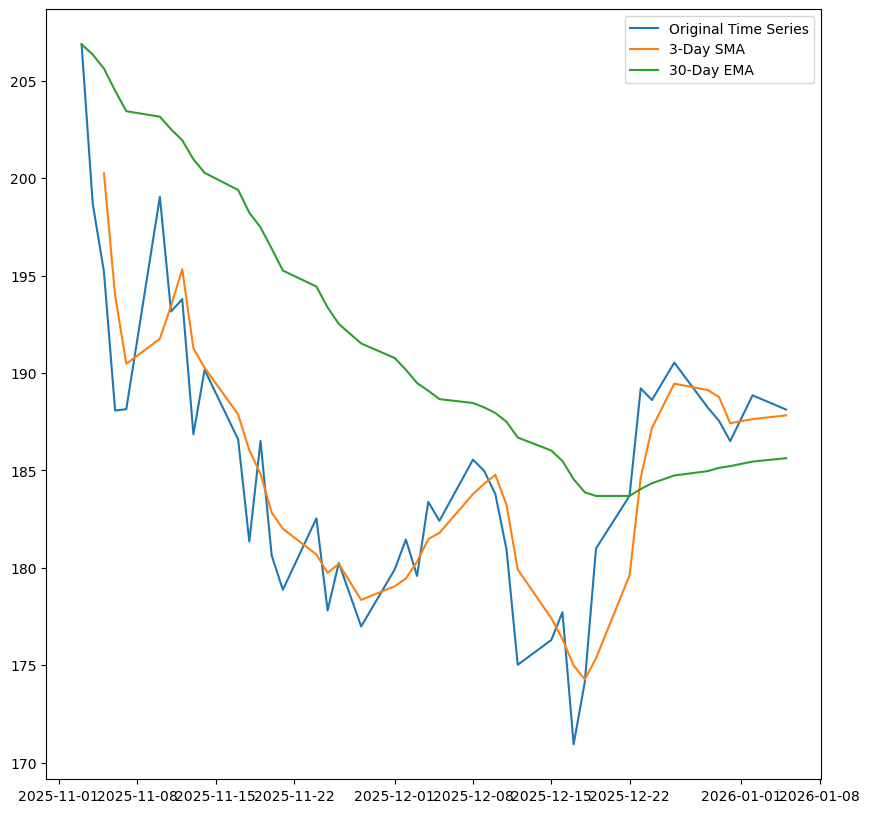

In [22]:
fig,ax =plt.subplots(figsize=(10,10))

ax.plot(df_5month, label='Original Time Series')
ax.plot(sma, label=f'{sma_window}-Day SMA')
ax.plot(ema, label=f'{ema_window}-Day EMA')
ax.legend()

# Model Developement

### Train Test Split

In [23]:
# train = df[df.index<"2025-08-01"]
# test  = df.loc['2025-09-01':'2025-12-29',:]

sample = df.loc["2025-01-05":"2026-01-05"]

In [24]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    Splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data) * (1 - test_size - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    
    return df_train, df_val, df_test


# Create data split
df_train, df_val, df_test = split_data(sample)

In [25]:
X_train = df_train['Close']
X_val = df_val['Close']
X_test = df_test['Close']
X_both = np.hstack((X_train, X_val))

### Model 1 (Simple) --> PDARIMA

In [26]:
model = pm.auto_arima(
    X_both,
    seasonal=True,
    m=12,
    trace=True,
    error_action="ignore",
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1292.869, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1299.838, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1297.187, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1298.478, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1298.061, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1294.996, Time=1.40 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1294.474, Time=1.12 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1293.269, Time=4.12 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1293.431, Time=2.86 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1294.515, Time=0.78 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1291.794, Time=2.97 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=1294.235, Time=1.32 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=1295.316, Time=1.63 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=1293.556, Time=4.24 sec
 ARIMA(2,1,3)(0,0,2

In [35]:
model1 = ARIMA(X_train,order=(0, 1, 4),seasonal_order=(2, 0, 0, 12))

In [36]:
model1_fit=model1.fit()

In [37]:
forecast_model1 = ARIMA(X_both,order=(0, 1, 4),seasonal_order=(2, 0, 0, 12))

In [38]:
forecast_result = forecast_model1.filter(model1_fit.params)

In [39]:
forecast_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  225
Model:             ARIMA(0, 1, 4)x(2, 0, [], 12)   Log Likelihood                -638.159
Date:                           Tue, 06 Jan 2026   AIC                           1290.318
Time:                                   16:47:33   BIC                           1314.199
Sample:                                        0   HQIC                          1299.958
                                           - 225                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1255      0.051     -2.439      0.015      -0.226      -0.025
ma.L2          0.1712      0.073      2.332      0.020       0.027       0.315
ma.L3         -0.1457      0.066     -2.208      0.027      -0.275      -0.016
ma.L4         -0.1016      0.062     -1.636      0.102      -0.223       0.020
ar.S.L12       0.1198      0.063      1.915      0.055      -0.003       0.242
ar.S.L24       0.1888      0.070      2.681      0.007       0.051       0.327
sigma2        16.0143      1.076     14.882      0.000      13.905      18.123
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               131.59
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.54
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
X_pred = forecast_result.forecast(steps=len(X_test))

In [41]:
mse = mean_squared_error(X_test.values,X_pred)
mse

47.92455527350576

In [42]:
rmse = root_mean_squared_error(X_test.values,X_pred)
rmse

6.9227563349800025

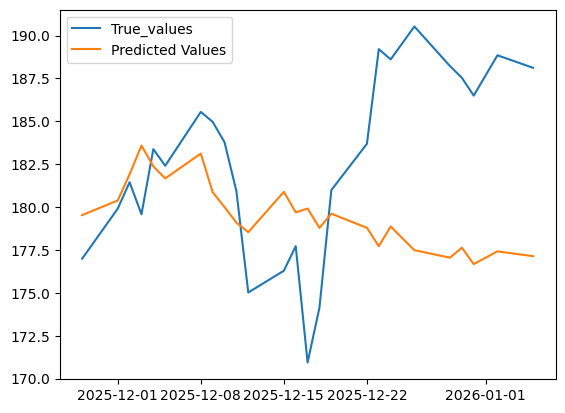

In [43]:
fig,ax =plt.subplots()
ax.plot(X_test.index,X_test.values, label="True_values")
ax.plot(X_test.index,X_pred, label="Predicted Values")
ax.legend()

### Model 2  --> SARIMAX (same hyperparameter as model1)

In [48]:
model2 = SARIMAX(X_train,order=(0, 1, 4),seasonal_order=(2, 0, 1, 12))

In [49]:
model2_fit = model2.fit()

In [50]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  200
Model:             SARIMAX(0, 1, 4)x(2, 0, [1], 12)   Log Likelihood                -558.975
Date:                              Tue, 06 Jan 2026   AIC                           1133.950
Time:                                      16:49:37   BIC                           1160.297
Sample:                                           0   HQIC                          1144.613
                                              - 200                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1256      0.060     -2.082      0.037      -0.244      -0.007
ma.L2          0.1698      0.086      1.964      0.050       0.000       0.339
ma.L3         -0.1450      0.075     -1.945      0.052      -0.291       0.001
ma.L4         -0.1007      0.072     -1.403      0.161      -0.241       0.040
ar.S.L12       0.2095      0.522      0.401      0.688      -0.814       1.233
ar.S.L24       0.1761      0.123      1.437      0.151      -0.064       0.416
ma.S.L12      -0.0934      0.529     -0.176      0.860      -1.131       0.944
sigma2        16.0105      1.312     12.199      0.000      13.438      18.583
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               219.61
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
forecast_model2 = SARIMAX(X_both,order=(0, 1, 4),seasonal_order=(2, 0, 1, 12))

In [52]:
forecast_result2 = forecast_model2.filter(model2_fit.params)

In [53]:
forecast_result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  225
Model:             SARIMAX(0, 1, 4)x(2, 0, [1], 12)   Log Likelihood                -638.122
Date:                              Tue, 06 Jan 2026   AIC                           1292.243
Time:                                      16:49:46   BIC                           1319.537
Sample:                                           0   HQIC                          1303.260
                                              - 225                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1256      0.052     -2.431      0.015      -0.227      -0.024
ma.L2          0.1698      0.074      2.305      0.021       0.025       0.314
ma.L3         -0.1450      0.066     -2.184      0.029      -0.275      -0.015
ma.L4         -0.1007      0.062     -1.613      0.107      -0.223       0.022
ar.S.L12       0.2095      0.482      0.434      0.664      -0.736       1.155
ar.S.L24       0.1761      0.114      1.542      0.123      -0.048       0.400
ma.S.L12      -0.0934      0.484     -0.193      0.847      -1.042       0.855
sigma2        16.0105      1.077     14.859      0.000      13.899      18.122
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               131.81
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.54
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
X_pred2 = forecast_result2.forecast(steps=len(X_test))

In [55]:
mse2 = mean_squared_error(X_test.values,X_pred2)
mse2

46.116365076124524

In [56]:
rmse2 = root_mean_squared_error(X_test.values,X_pred)
rmse2

6.9227563349800025

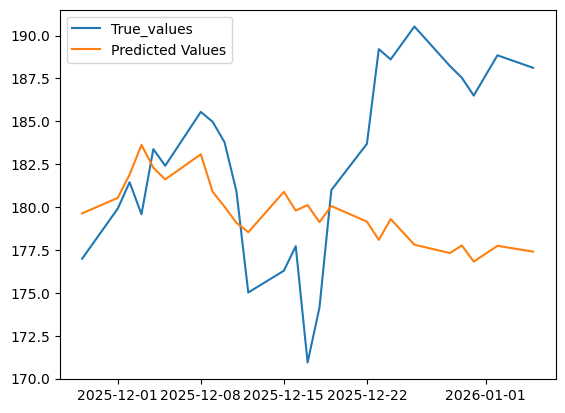

In [57]:
fig,ax =plt.subplots()
ax.plot(X_test.index,X_test.values, label="True_values")
ax.plot(X_test.index,X_pred2, label="Predicted Values")
ax.legend()

### HyperParameter Tuning method 1 - Model 3

In [58]:
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s = 12

param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

best_aic = float('inf')
best_params = None

for p, d, q, P, D, Q in param_grid:
    model = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
    aic = model.aic
    if aic < best_aic:
        best_aic = aic
        best_params = (p, d, q, P, D, Q)

print(f"Best parameters: {best_params} with AIC: {best_aic}")

Best parameters: (2, 1, 0, 0, 1, 1) with AIC: 1088.00958557153


In [59]:
model3 = SARIMAX(X_train,order=(2, 1, 0),seasonal_order=(0, 1, 1, 12))

In [60]:
model3_fit = model3.fit()

In [61]:
model3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  200
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -540.005
Date:                              Tue, 06 Jan 2026   AIC                           1088.010
Time:                                      16:51:20   BIC                           1100.934
Sample:                                           0   HQIC                          1093.247
                                              - 200                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1127      0.074     -1.532      0.126      -0.257       0.032
ar.L2          0.1571      0.085      1.839      0.066      -0.010       0.324
ma.S.L12      -0.7795      0.063    -12.282      0.000      -0.904      -0.655
sigma2        17.7646      1.298     13.688      0.000      15.221      20.308
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.09
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
forecast_model3 = SARIMAX(X_both,order=(2, 1, 0),seasonal_order=(0, 1, 1, 12))

In [63]:
forecast_result3 = forecast_model3.filter(model3_fit.params)

In [64]:
X_pred3 = forecast_result3.forecast(steps=len(X_test))

In [65]:
mse3 = mean_squared_error(X_test.values,X_pred3)
mse3

32.50003233134562

In [66]:
rmse3 = root_mean_squared_error(X_test.values,X_pred)
rmse3

6.9227563349800025

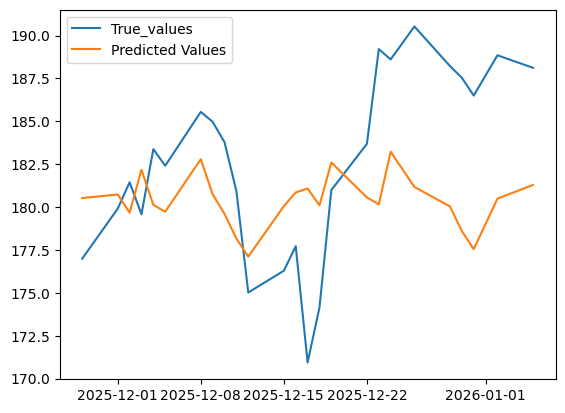

In [67]:
fig,ax =plt.subplots()
ax.plot(X_test.index,X_test.values, label="True_values")
ax.plot(X_test.index,X_pred3, label="Predicted Values")
ax.legend()

In [129]:
# As Model complexity increases the Variance increase model become overfit performs well for train data not for test data
# Example when seasonal_order was (0, 1, 1, 12) mse for test was 32 but when it was (0, 2, 2, 12) it was 99 but train mse was good.

### HyperParameter Tuning using optuna - Model 4

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
def objective_sarima(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    trend=trial.suggest_categorical('trend',['n','c','t','ct',None])
    model=SARIMAX(X_train,order=order, seasonal_order=seasonal_order,trend=trend,initialization='approximate_diffuse')
    mdl = model.fit(disp=0) #disp=0
    predictions = mdl.forecast(len(X_test))
    predictions = pd.Series(predictions, index=X_test.index)
    residuals = X_test - predictions
    mse=np.sqrt(np.mean(residuals**2))
    accuracy=mse
    return accuracy

study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima,n_trials=10)